# Startup

In [8]:
from importlib import reload
from datetime import date
from os import path, makedirs

import numpy as np
import matplotlib.pyplot as plt
# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.operators.crossover.sbx import SBX
# from pymoo.operators.mutation.pm import PM
# from pymoo.operators.sampling.rnd import FloatRandomSampling
# from pymoo.termination import get_termination
# from pymoo.optimize import minimize
# from pymoo.core.problem import Problem
import pandas as pd
# import plotly.express as px

# from cam_class_optimization import CamGeneration
import cam_class_optimization
from cam_class_optimization import CamGeneration

# Define problem parameters. Forces are in Newtons, lengths are in meters.
user_height = 1.654 # 1.654 is avg. height of subjects 55+ in NHANES 2017-2020
k_elastic = 200
sit_angle_deg = 220
offset_angle_deg = 180
target_force_max = 200
target_force_range = 25
target_percentage_max = 32.5
target_percentage_range = 5
target_sitting_max = 25
target_radius_max = 0.0635
dateStr = date.today().strftime("%Y-%m-%d")

# Load sit-to-stand inner cam point cloud in Cartesian coordinates.
folder_path = 'results/cam_plots/cam_plots_2024-06-13_K=100/'
cam_idx = 63
points_stand = np.array(pd.read_csv(f'{folder_path}inner_{cam_idx}.txt',
                                    header=None, usecols=[0,1])) / 1000
points_outer = np.array(pd.read_csv(f'{folder_path}outer_{cam_idx}.txt',
                                    header=None, usecols=[0,1])) / 1000

# Junk code for CamGeneration init
x = np.ones(17)
gear_ratios = x[: 8]
input_angles = x[8 : -1]
scaling = x[-1]

INTIAL GUESS PATH LENGTH: 0.08233084376701144
Total energy stored in elastic band: 0.5619212181497698 J
INITIAL GUESS OBJECTIVE VALUE: 56.86663109469394


<Figure size 640x480 with 0 Axes>

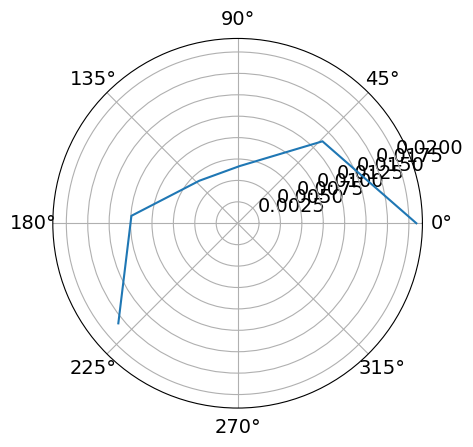

Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy stored in elastic band: 0.5619212181497698 J
Total energy s

<Figure size 640x480 with 0 Axes>

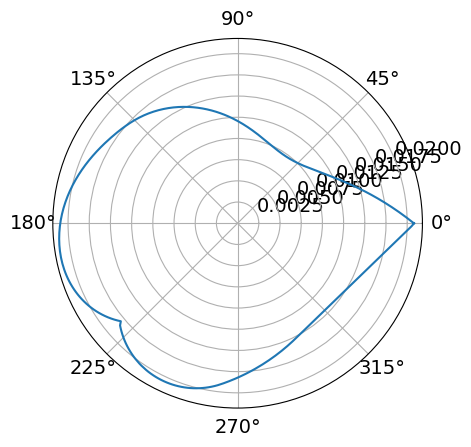

In [9]:
# Create CamGeneration object.
reload(cam_class_optimization)
from cam_class_optimization import CamGeneration
Cam = CamGeneration(gear_ratios, input_angles, scaling,
                    sit_angle=np.pi/180*sit_angle_deg,
                    offset_angle=np.pi/180*offset_angle_deg)

 # Convert point cloud to polar coordinates.
radii_stand, angles_stand = Cam.to_polar(points_stand)
radii_outer, angles_outer = Cam.to_polar(points_outer)

n_params = 6
result, radii_sit, x_cable_sit = Cam.generate_sit_cam(radii_stand, angles_stand,
                                                      radii_outer, k_elastic,
                                                      n_params)

Total energy stored in elastic band: 2.753881076821683 J


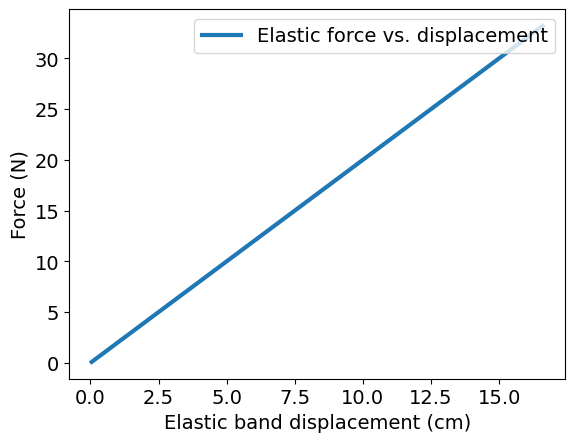

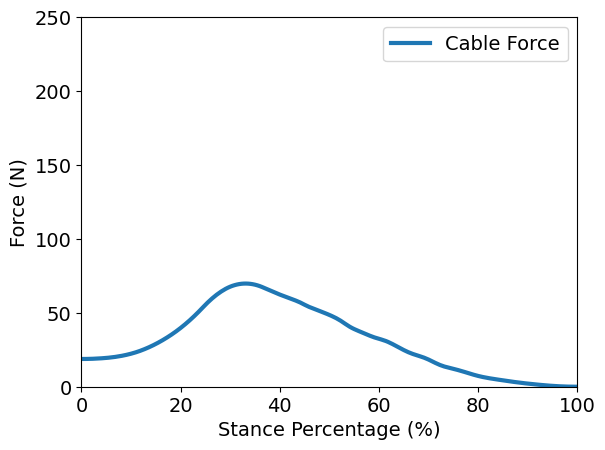

In [10]:
# Put stand-to-sit cam and outer cam shapes together in an array.
cam_radii_sit = np.vstack((radii_sit, radii_outer)).T

plot=True
index=cam_idx
forces, percentages = Cam.calc_forces(cam_radii_sit, x_cable_sit,
                                      k_elastic, torque=False,
                                      plot=plot, index=index)

Total energy stored in elastic band: 2.753881076821683 J


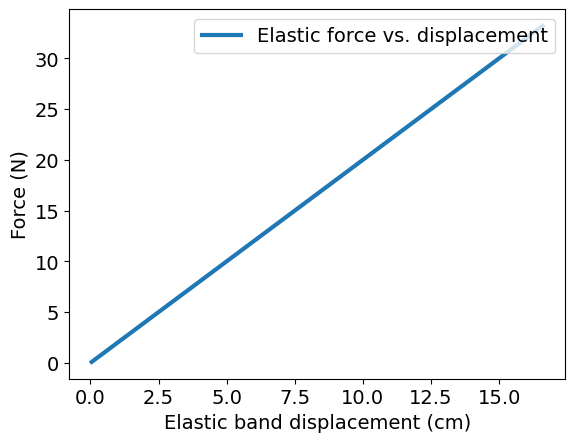

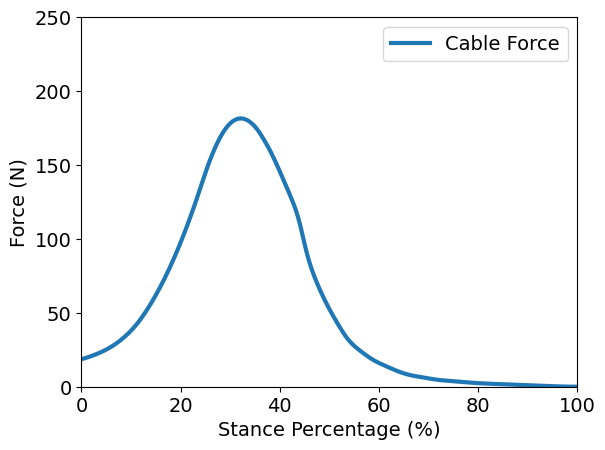

In [12]:
# Check energy release in sit-to-stand cam
cam_radii_stand = np.vstack((radii_stand, radii_outer)).T
x_cable_stand = np.cumsum(radii_stand * 2*np.pi / 360)
plot=True
index=cam_idx
forces, percentages = Cam.calc_forces(cam_radii_stand, x_cable_stand,
                                      k_elastic, torque=False,
                                      plot=plot, index=index)